In [19]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import PIL
from glob import glob
import copy

from dataset.dataset_unet import mask2data
from utils.mask_functions import rle2mask

train_fname_list = glob(r"../data/processed/*")
test_fname_list = glob('../data/processed/test/*')
print('how many images in trainset folder: ', len(train_fname_list))
print('how many images in testset folder: ', len(test_fname_list))

np.random.seed(2018)

mask_data = mask2data()
def get_mask(fname, mask_data):
    img_id = fname.split('/')[-1][:-4]
    try:
        rle = [m for m in mask_data if m['img_id']==img_id][0]['masks'][0]
        return rle2mask(rle, 1024, 1024).T
    except:
        return np.zeros((1024, 1024))
print('how many masks in trainset: ', len(mask_data))

%matplotlib inline

how many images in trainset folder:  12090
how many images in testset folder:  0
how many masks in trainset:  12047


## 图片读取工具
- Matplotlib
- OpenCV
- PIL (Python Image Library)

../data/processed/1.2.276.0.7230010.3.1.4.8323329.32619.1517875161.506662.png


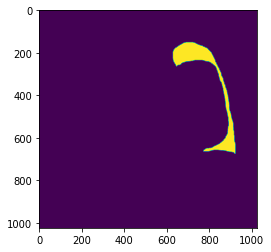

In [31]:
fname = np.random.choice(train_fname_list, 1)[0]
print(fname)
mask = get_mask(fname, mask_data)
plt.imshow(mask)

**Matplotlib**

<class 'numpy.ndarray'>
(1024, 1024)
0.0 0.9607843


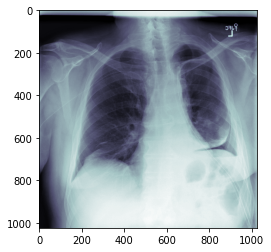

In [32]:
img = plt.imread(fname)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

**OpenCV**

<class 'numpy.ndarray'>
(1024, 1024)
0 245


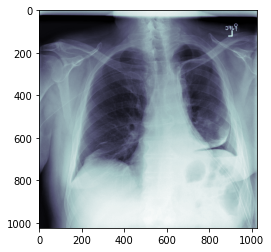

In [33]:
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

**PIL**

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
(1024, 1024)
0 245


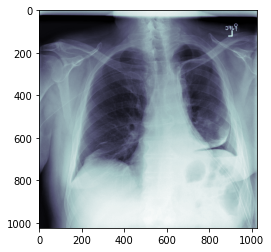

In [34]:
img = PIL.Image.open(fname)
print(type(img))
img = np.asarray(img)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

## 数据集可视化
- 在图上画出Mask
- 同时展示20张图片

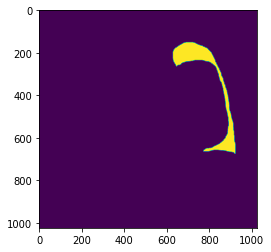

In [35]:
mask = get_mask(fname, mask_data)
plt.imshow(mask)

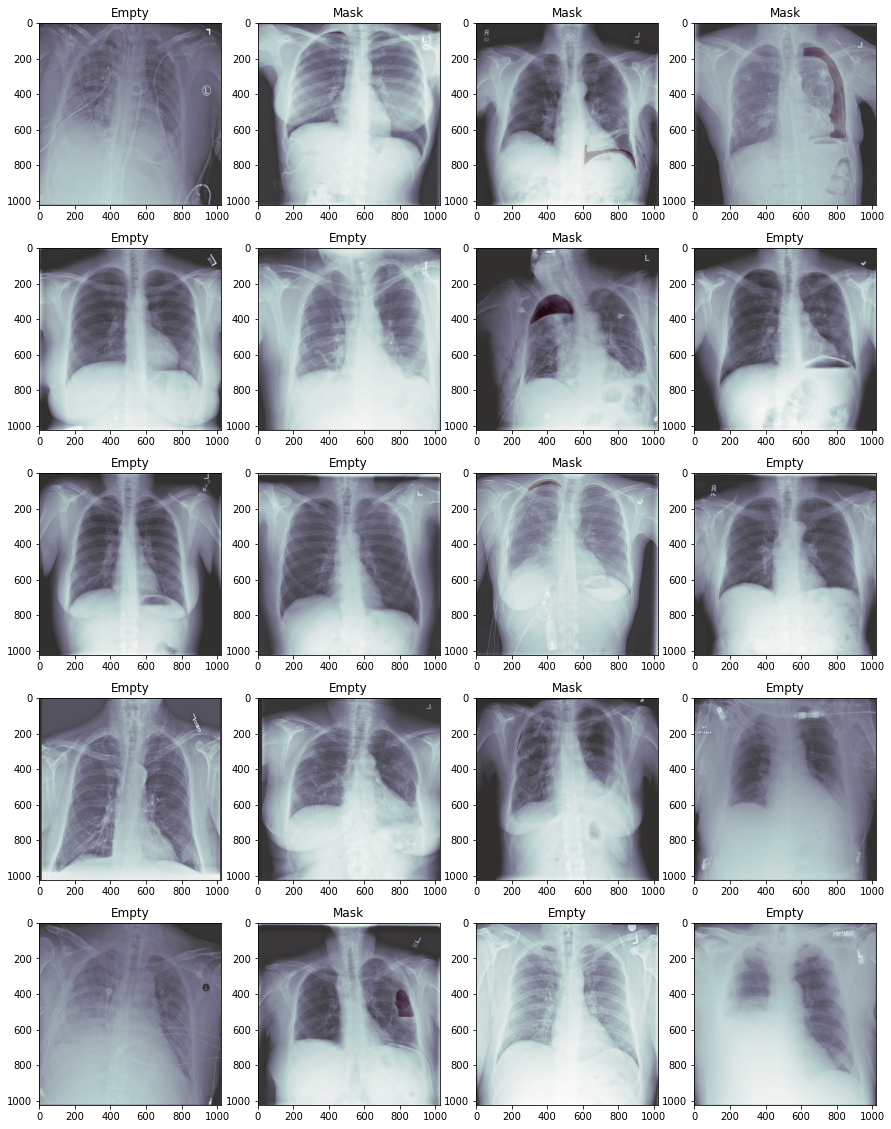

In [36]:
random_image_list = np.random.choice(train_fname_list, 20)

visualize_mask = True

## visualize batch of images
fig = plt.figure(figsize=(15, 20))
for idx, img_fname in enumerate(random_image_list):
    img = plt.imread(img_fname)
    ax = fig.add_subplot(5, 4, idx+1)
    plt.imshow(img, plt.cm.bone)
    
    if visualize_mask:
        mask = get_mask(img_fname, mask_data)
        plt.imshow(mask, alpha=0.2, cmap="Reds")
        if mask.sum()>0:
            plt.title('Mask')
        else:
            plt.title('Empty')
# 正样本比例很低，而且mask比例很小。可以尝试focal loss

## 3通道图像 vs 1通道图像
- 1-通道图片: Grayscale，黑白
- 3-通道图片: RGB，彩色
- 1通道-->3通道图片转换

(1024, 1024)


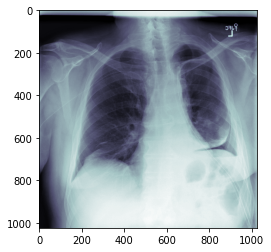

In [39]:
img = plt.imread(fname)
print(img.shape)  # 1024 * 1024
fig = plt.imshow(img, cmap=plt.cm.bone)

In [42]:
new_img = img.reshape(img.shape[0], img.shape[1], 1)
new_img.shape

(1024, 1024, 1)

In [43]:
mean=[0.485, 0.456, 0.406]
std =[0.229, 0.224, 0.225]
# 用上面的均值和方差对原图进行三次转换，转换后的三层拼接在一起，就变成了三层的彩色图片
img_three_channel = np.concatenate([
                                    (new_img-mean[0])/std[0],
                                    (new_img-mean[1])/std[1],
                                    (new_img-mean[2])/std[2],
                                    ], axis=2)
img_three_channel = np.clip(img_three_channel, 0, 1)
img_three_channel.shape

(1024, 1024, 3)

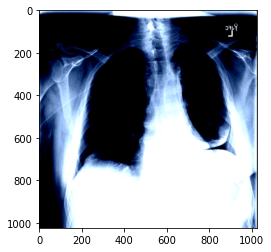

In [44]:
fig = plt.imshow(img_three_channel, cmap=plt.cm.bone)

## 图像运算
#### 工具：
1. Numpy
2. OpenCV

#### 操作：
- 翻转
- 旋转
- 亮度调节
- 透视变换
- 添加遮罩
- 剪切

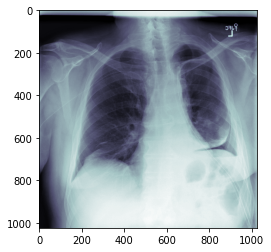

In [45]:
plt.imshow(img, cmap=plt.cm.bone)

In [46]:
# 矩阵
print(img.shape)
img

(1024, 1024)


array([[0.81960785, 0.8156863 , 0.81960785, ..., 0.7490196 , 0.79607844,
        0.5254902 ],
       [0.8039216 , 0.8       , 0.8       , ..., 0.7490196 , 0.7921569 ,
        0.5137255 ],
       [0.79607844, 0.7882353 , 0.7882353 , ..., 0.7529412 , 0.78431374,
        0.5019608 ],
       ...,
       [0.05098039, 0.05098039, 0.04705882, ..., 0.6784314 , 0.7411765 ,
        0.49803922],
       [0.05098039, 0.05098039, 0.04705882, ..., 0.6784314 , 0.74509805,
        0.49803922],
       [0.05098039, 0.05098039, 0.04705882, ..., 0.68235296, 0.7529412 ,
        0.5019608 ]], dtype=float32)

#### 整体操作

Text(0.5, 1.0, 'flip lr')

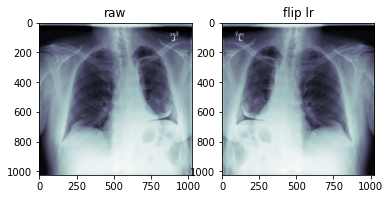

In [48]:
## 左右翻转
#img_flip_lr = img[:, ::-1]  # 行不变，列翻转
img_flip_lr = cv2.flip(img, 1)  # 在1维度上进行翻转

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_flip_lr, cmap=plt.cm.bone)
ax1.set_title('flip lr')

Text(0.5, 1.0, 'flip ud')

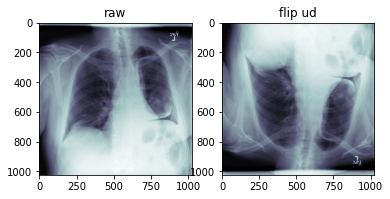

In [47]:
## 上下翻转
img_flip_ud = img[::-1, :]
#img_flip_ud = cv2.flip(img, 0)  # 在维度0上翻转

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_flip_ud, cmap=plt.cm.bone)
ax1.set_title('flip ud')

Text(0.5, 1.0, 'rotate')

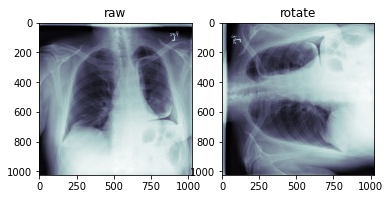

In [50]:
## （逆时针）旋转90"、180"、270"、360"
img_rot = np.rot90(img, 1)
#img_rot = np.rot90(img, 2)
# img_rot = np.rot90(img, 3)
# img_rot = np.rot90(img, 4)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_rot, cmap=plt.cm.bone)
ax1.set_title('rotate')

Text(0.5, 1.0, 'bright')

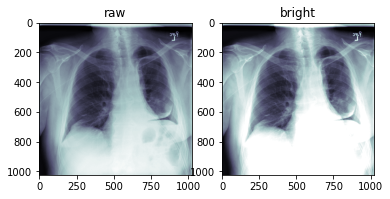

In [51]:
## 亮度调节
# 读进来的数据是0~1之间的，0暗1亮
img_bright = img + 0.25 #+-0.25
img_bright = np.clip(img_bright, 0, 1)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_bright, cmap=plt.cm.bone)
ax1.set_title('bright')

Text(0.5,1,'perspective transform')

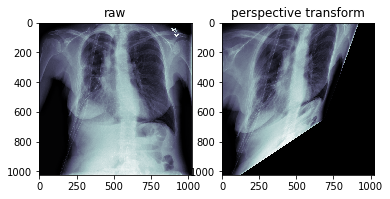

In [14]:
## 透视变换
def do_perspective_transform(image):
    pts1 = np.float32([[200, 200], [800, 200], [200, 800], [800, 800]])
    #pts2 = np.float32([[350, 350], [950, 350], [350, 850], [850, 850]])
    pts2 = np.float32([[100, 300], [750, 100], [100, 900], [600, 600]])
    #pts2 = np.float32([[50, 50], [750, 150], [150, 750], [950, 950]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image, M, image.shape)
    return image

img_perspective = do_perspective_transform(img)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_perspective, cmap=plt.cm.bone)
ax1.set_title('perspective transform')

#### 局部操作

141 255


Text(0.5, 1.0, 'add mask')

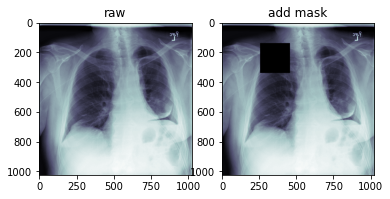

In [52]:
## 局部操作一：添加遮罩
mask = np.zeros((200, 200))
#mask = np.random.random(size=(200, 200))
x, y = np.random.randint(0, 700), np.random.randint(0, 700)
print(x, y)
img_copy = copy.deepcopy(img)
img_copy[x:x+200, y:y+200] = mask


fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_copy, cmap=plt.cm.bone)
ax1.set_title('add mask')

Text(0.5,1,'crop and pad')

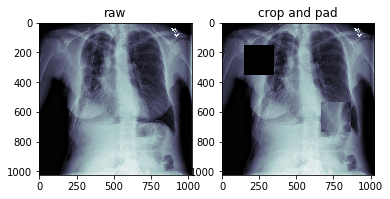

In [16]:
## 局部操作二：剪切一个正方形，粘贴到其他位置(x0,y0)-->(x1,y1)
# 这样看似不合理，但是可能会对结果产生正作用
x0, y0 = np.random.randint(0, 700), np.random.randint(0, 700)
x1, y1 = np.random.randint(0, 700), np.random.randint(0, 700)
crop = img[x0:x0+200, y0:y0+200]
img_copy = copy.deepcopy(img)
img_copy[x1:x1+200, y1:y1+200] = crop
img_copy[x0:x0+200, y0:y0+200] = 0

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_copy, cmap=plt.cm.bone)
ax1.set_title('crop and pad')

## 训练数据集准备
- 工具sklearn
    - train_test_split
- 切分方式
    - 随机切分
    - stratification
        - 按照正负样本比例
        - 按业务知识切分

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

#### 先讲一个机器学习的例子

In [54]:
# 生成伪样本
X, y = make_classification(n_samples=100, n_features=4, n_classes=2)
X.shape, y.shape

((100, 4), (100,))

In [55]:
train_index, valid_index = train_test_split(list(range(X.shape[0])), test_size=0.1, random_state=2019)

X_train, y_train = X[train_index, :], y[train_index]
X_valid, y_valid = X[valid_index, :], y[valid_index]

X_train.shape, X_valid.shape

((90, 4), (10, 4))

In [56]:
train_index

[42,
 19,
 18,
 98,
 69,
 60,
 9,
 70,
 63,
 43,
 20,
 4,
 77,
 97,
 0,
 35,
 39,
 32,
 23,
 49,
 30,
 44,
 86,
 56,
 41,
 36,
 76,
 14,
 68,
 93,
 2,
 22,
 85,
 81,
 40,
 47,
 25,
 95,
 34,
 99,
 90,
 64,
 84,
 67,
 59,
 75,
 38,
 78,
 79,
 17,
 82,
 27,
 26,
 52,
 3,
 7,
 55,
 8,
 57,
 58,
 53,
 33,
 61,
 51,
 11,
 10,
 54,
 65,
 92,
 89,
 21,
 28,
 94,
 5,
 50,
 80,
 91,
 83,
 71,
 48,
 16,
 12,
 15,
 29,
 24,
 62,
 88,
 37,
 31,
 72]

#### 图像数据集，用图片文件名作为ID，切分为两个包含ID集合的训练集、验证集

In [57]:
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, random_state=2019)
print('数据集图片数量： ', len(train_fname_list))
print('训练集图片数量：%d，验证集图片数量：%d'%(len(train_fnames), len(valid_fnames)))

数据集图片数量：  12090
训练集图片数量：10881，验证集图片数量：1209


In [58]:
train_fnames[:10]

['../data/processed/1.2.276.0.7230010.3.1.4.8323329.579.1517875163.536413.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.12858.1517875242.221747.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.31861.1517875157.200473.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.3429.1517875177.805141.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.14015.1517875249.142866.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.13789.1517875247.946630.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.5200.1517875186.925660.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.32516.1517875160.956624.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.10988.1517875229.183153.png',
 '../data/processed/1.2.276.0.7230010.3.1.4.8323329.13842.1517875248.230485.png']

#### stratification切分

In [59]:
sex = np.random.choice([0,1], size=len(y), p=[0.2, 0.8])
sex[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [60]:
train_index, valid_index = train_test_split(list(range(X.shape[0])), test_size=0.1, random_state=2019, 
                                            stratify=sex)

#### 图像数据里怎么用好stratification切分？

In [61]:
## 根据每张图片中mask个数切分，0/1，使训练集和验证集的0/1分布尽量接近
train_fname_list = [item['img_id'] for item in mask_data]
cnt_masks = [1 if item['cnt_masks']>0 else 0 for item in mask_data]
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, 
                                              stratify=cnt_masks, random_state=2019)

In [62]:
len(train_fnames), len(valid_fnames)

(10842, 1205)

跟业务知识有关的切分，比如按图片采集的时间切分、按图片采集设备的切分、按生产环境真实图片特点切分等

In [63]:
import datetime
fake_time_of_image = [datetime.datetime.today() -
                      datetime.timedelta(
                          days=np.random.randint(0, 365)) for _ in range(len(train_fname_list))]
fake_time_of_image[:4]

[datetime.datetime(2019, 12, 13, 6, 56, 49, 377106),
 datetime.datetime(2019, 12, 29, 6, 56, 49, 377164),
 datetime.datetime(2020, 5, 13, 6, 56, 49, 377176),
 datetime.datetime(2020, 1, 5, 6, 56, 49, 377186)]

In [65]:
## 过去12个月～1个月前作为训练集，最近一个月作为验证集
train_index = [i for i,time in enumerate(fake_time_of_image) if (datetime.datetime.today() - time).days>30]
valid_index = [i for i,time in enumerate(fake_time_of_image) if (datetime.datetime.today() - time).days<=30]
len(train_index), len(valid_index)

(11018, 1029)

比如客户提供的数据集95%是扫描的高清图片，5%是手机拍照的图片。生产环境却是100%手机拍照的质量。
5%全部的手机照片 + 5%的扫描图片作为验证集

In [66]:
device = np.random.choice(['phone', 'scan'], p=[0.05, 0.95], size=len(train_fname_list))
device[:20]

array(['scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan',
       'scan', 'scan', 'scan', 'scan', 'scan', 'phone', 'scan', 'scan',
       'scan', 'scan', 'scan', 'scan'], dtype='<U5')

In [67]:
index_scan = [i for i,d in enumerate(device) if d=='scan']
index_photo = [i for i,d in enumerate(device) if d=='phone']
len(index_scan), len(index_photo)

(11432, 615)

In [68]:
train_index, valid_index_scan = train_test_split(index_scan, test_size=0.05, random_state=2019)
valid_index = valid_index_scan + index_photo
len(train_index), len(valid_index)

(10860, 1187)

#### 本次医疗X光片数据集切分办法，根据疑似症状部位数量



In [69]:
mask_data = mask2data()
train_fname_list = [item['img_id'] for item in mask_data]
cnt_masks = [item['cnt_masks'] if item['cnt_masks']<5 else 5 for item in mask_data]

In [70]:
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, 
                                              stratify=cnt_masks, random_state=2019)

In [71]:
#在有症状的人中，症状数存在1～5个部位，5种情况
pd.value_counts(cnt_masks) / len(cnt_masks)

0    0.778451
1    0.169752
2    0.037105
3    0.009297
4    0.003320
5    0.002075
dtype: float64

In [78]:
_idx = 25
_img_id = [item for item in mask_data if item['cnt_masks']==4][_idx]['img_id']  # 查看有四个阴影的图片
_img_id

'1.2.276.0.7230010.3.1.4.8323329.32761.1517875162.229147'

In [79]:
_masks = pd.read_csv('../data/raw/train-rle.csv').set_index('ImageId').loc[_img_id, ' EncodedPixels'].tolist()

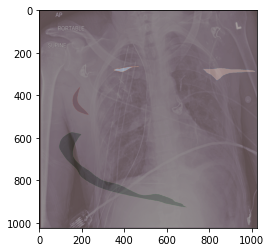

In [81]:
plt.imshow(plt.imread('../data/processed/%s.png'%_img_id), cmap=plt.cm.bone)
plt.imshow(rle2mask(_masks[0], 1024, 1024), alpha=0.25, cmap='Reds')
plt.imshow(rle2mask(_masks[1], 1024, 1024), alpha=0.25, cmap='Greens')
plt.imshow(rle2mask(_masks[2], 1024, 1024), alpha=0.25, cmap='Blues_r')
plt.imshow(rle2mask(_masks[3], 1024, 1024), alpha=0.25, cmap='Oranges_r')